In [ ]:
import os
import sys

sys.path.append(os.path.abspath(".."))

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from scipy import stats
from stable_baselines3 import DQN

from apad_env import APADEnv

# Peak into model

In [10]:
model = DQN.load("apad_dqn_model")

### What does the q table and its values look like

In [11]:
env = APADEnv()
obs, _ = env.reset()
q_values = model.q_net(model.policy.obs_to_tensor(obs)[0])
print(f"Q-value range: {q_values.min():.3f} to {q_values.max():.3f}")
print(f"Mean Q-value: {q_values.mean():.3f}")
print(f"Q-values shape: {q_values.shape}")
print(f"Number of actions: {q_values.numel()}")
print(f"First 10 Q-values: {q_values[:10]}")
print(f"Unique Q-values: {len(torch.unique(q_values))}")
total_params = sum(p.numel() for p in model.policy.q_net.parameters())
print(f"Total parameters: {total_params:,}")
print(model.policy.q_net)

Q-value range: -181.909 to 664.729
Mean Q-value: 449.763
Q-values shape: torch.Size([1, 2752])
Number of actions: 2752
First 10 Q-values: tensor([[356.5075, 346.3496, 415.1599,  ..., 443.9122, 473.1432, 408.4503]],
       grad_fn=<SliceBackward0>)
Unique Q-values: 2752
Total parameters: 186,752
QNetwork(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (q_net): Sequential(
    (0): Linear(in_features=57, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2752, bias=True)
  )
)


Input (57) → Hidden Layer 1 (64) → Hidden Layer 2 (64) → Output (2,752)

### look at the distribution of q values

In [12]:
q_vals = q_values.detach().numpy().flatten()

gaussian: mean=449.763, std dev=85.760
log-normal: shape=0.010, loc=-8036.322, scale=8667.562


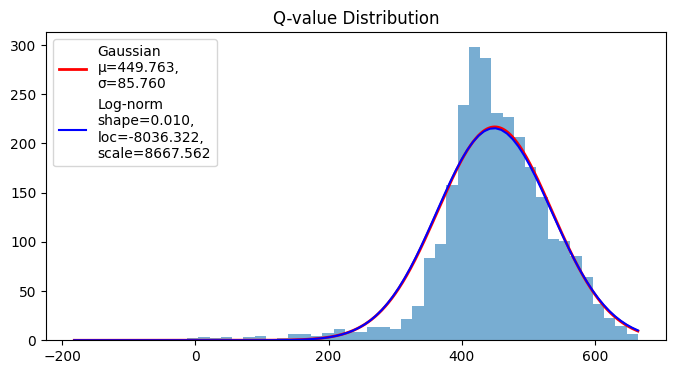

In [13]:
plt.figure(figsize=(8, 4))
counts, bins, _ = plt.hist(q_vals, bins=50, alpha=0.6)

##########
# gaussian
##########
mu, std = stats.norm.fit(q_vals)

print(f"gaussian: mean={mu:.3f}, std dev={std:.3f}")

# Generate x-values for the Gaussian curve
x = np.linspace(bins[0], bins[-1], 1000)

bin_width = bins[1] - bins[0]
gaussian = stats.norm.pdf(x, mu, std) * len(q_vals) * bin_width

plt.plot(x, gaussian, "r-", linewidth=2, label=f"Gaussian\nμ={mu:.3f},\nσ={std:.3f}")

##########
# lognorm
##########
q_vals_shifted = q_vals - q_vals.min() + 1e-6  # Shift to make positive

shape, loc, scale = stats.lognorm.fit(q_vals_shifted)
print(f"log-normal: shape={shape:.3f}, loc={loc:.3f}, scale={scale:.3f}")

x = np.linspace(q_vals.min(), q_vals.max(), 100)
x_shifted = x - q_vals.min() + 1e-6
lognorm = stats.lognorm.pdf(x_shifted, shape, loc, scale) * len(q_vals) * bin_width
plt.plot(x, lognorm, "b-", label=f"Log-norm\nshape={shape:.3f},\nloc={loc:.3f},\nscale={scale:.3f}")

##########
# plot
##########
plt.legend()
plt.title("Q-value Distribution")
plt.savefig("qvals.png")
plt.show()

## what is the best starting move?

Chosen action: 1572
piece id: 4, chirality: 1, rotation: 0, position: 24


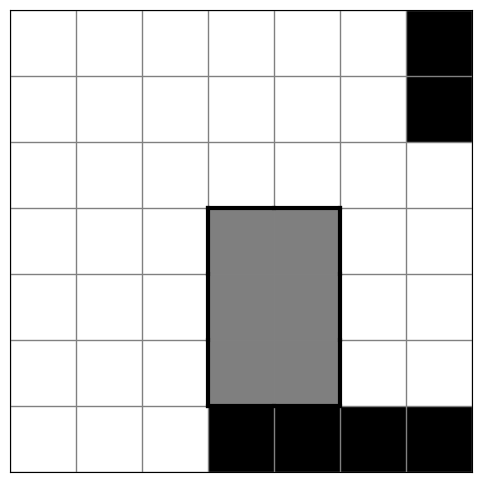

In [14]:
action, _ = model.predict(obs, deterministic=True)
print(f"Chosen action: {action}")
piece_id = action // (2 * 4 * 43)
remaining = action % (2 * 4 * 43)
chirality = remaining // (4 * 43)
remaining = remaining % (4 * 43)
rotation = remaining // 43
position = remaining % 43
print(f"piece id: {piece_id}, chirality: {chirality}, rotation: {rotation}, position: {position}")

env.step(action)
env.visualize()

### throw some randomness into the best starting move

In [15]:
# Analyze first move preferences
first_moves = []
for _ in range(100):
    obs, _ = env.reset()
    action, _ = model.predict(obs, deterministic=False)

    # Decode action
    piece_id = action // (2 * 4 * 43)
    remaining = action % (2 * 4 * 43)
    chirality = remaining // (4 * 43)
    remaining = remaining % (4 * 43)
    rotation = remaining // 43
    position = remaining % 43

    first_moves.append((piece_id, chirality, rotation, position))

# Analyze preferences
df = pd.DataFrame(first_moves, columns=["piece", "chirality", "rotation", "position"])

df["piece_name"] = df["piece"].apply(lambda x: env.piece_names[x])

print("Piece preferences:")
piece_counts = df["piece_name"].value_counts()
print(piece_counts)

print(f"\nPieces never chosen first: {set(env.piece_names) - set(piece_counts.index)}")

print("\nChirality mean by piece:")
chirality_by_piece = df.groupby("piece_name")["chirality"].mean()
print(chirality_by_piece)

print("\nRotation mean by piece:")
rotation_by_piece = df.groupby("piece_name")["rotation"].mean()
print(rotation_by_piece)

print("\nPosition mean by piece:")
position_by_piece = df.groupby("piece_name")["position"].mean()
print(position_by_piece)

Piece preferences:
piece_name
R    90
C     3
K     2
I     1
Z     1
L     1
A     1
P     1
Name: count, dtype: int64

Pieces never chosen first: set()

Chirality mean by piece:
piece_name
A    1.000000
C    0.333333
I    0.000000
K    0.500000
L    1.000000
P    0.000000
R    0.988889
Z    1.000000
Name: chirality, dtype: float64

Rotation mean by piece:
piece_name
A    1.000000
C    0.666667
I    3.000000
K    2.500000
L    2.000000
P    0.000000
R    0.011111
Z    2.000000
Name: rotation, dtype: float64

Position mean by piece:
piece_name
A    27.000000
C    30.333333
I    33.000000
K    10.000000
L    24.000000
P    28.000000
R    23.700000
Z    36.000000
Name: position, dtype: float64
